In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
import os
from google.colab import userdata

# Retrieve the token from Colab secrets
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

from datasets import load_dataset

# Replace with the full identifier if prompted
dataset = load_dataset(
    "newsmediabias/news-bias-full-data",
    token = os.environ["HF_TOKEN"]
    )

# Inspect splits
print(dataset)

README.md:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.csv:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3674927 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50001 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
        num_rows: 3674927
    })
    test: Dataset({
        features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
        num_rows: 50001
    })
})


In [ ]:
df_train = dataset['train'].to_pandas()

In [ ]:
df_train.head()

,text,dimension,biased_words,aspect,label,sentiment,toxic,identity_mention
0,Where will this leave the kids??? That my frie...,Ageism and sentiment,[],Transphobia,Slightly Biased,Negative,0.0,NO
1,I had a feeling of impending doom &amp; then ...,Ageism and sentiment,"['impending', 'doom']",Climate change,Highly Biased,Negative,1.0,NO
2,I no feel good ..,Ageism and sentiment,[],Body-shaming,Neutral,Positive,0.0,NO
3,"Back in Hotlanta for a about a week, then off ...",Ageism and sentiment,[],Lifestyle,Slightly Biased,Negative,0.0,NO
4,Kids toys &amp; stamping stuff cleaned up... N...,Ageism and sentiment,[],Hobby,Neutral,Neutral,1.0,NO


In [ ]:
#take 200000 sample of text and put it into a new df for training
df_train = df_train.sample(n=100000, random_state=42)

In [ ]:
import re
import pandas as pd

# pip install langdetect

def clean_text(text):
    # Handle non-string inputs (e.g., None, NaN)
    if pd.isna(text):
        return ''
    # Ensure text is a string before applying regex
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to df_train
df_train['text'] = df_train['text'].apply(clean_text)

# Drop empty rows after cleaning
df_train = df_train[df_train['text'].str.strip() != '']

# Filter to English only
#df_train = df_train[df_train['text'].apply(is_english)]

df_train = df_train.reset_index(drop=True)
print(f"Rows remaining in df_train: {len(df_train)}")

Rows remaining in df_train: 99880


In [ ]:
print(df_train['label'].value_counts())

label
Neutral            51391
Slightly Biased    28252
Highly Biased      20237
Name: count, dtype: int64


In [ ]:
print(df_train['sentiment'].value_counts())

sentiment
Positive    45649
Negative    33293
Neutral     20938
Name: count, dtype: int64


In [ ]:
#starting to train the model
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from torch.optim import AdamW  # <-- fix here
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

In [ ]:
##Model to predict Label
le_label = LabelEncoder()
df_train['label_encoded'] = le_label.fit_transform(df_train['label'])

print(dict(zip(le_label.classes_, le_label.transform(le_label.classes_))))

X_train, X_val, y_train, y_val = train_test_split(
    df_train['text'], df_train['label_encoded'],
    test_size=0.2, random_state=42, stratify=df_train['label_encoded']
)


{'Highly Biased': np.int64(0), 'Neutral': np.int64(1), 'Slightly Biased': np.int64(2)}


In [ ]:
from IPython.utils import encoding
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_dataset(texts, tokenizer, max_len=64, batch_size=1000):
    all_input_ids = []
    all_attention_masks = []

    for i in range(0, len(texts), batch_size):
        batch = list(texts[i:i+batch_size])
        encoded = tokenizer(batch, max_length=max_len, padding='max_length', truncation=True, return_tensors='pt')
        all_input_ids.append(encoded['input_ids'])
        all_attention_masks.append(encoded['attention_mask'])
        if i % 10000 == 0:
            print(f"Tokenized {i}/{len(texts)}")

    return {
        'input_ids': torch.cat(all_input_ids),
        'attention_mask': torch.cat(all_attention_masks)
    }

train_encodings = tokenize_dataset(X_train, tokenizer)
val_encodings = tokenize_dataset(X_val, tokenizer)

Tokenized 0/79904
Tokenized 10000/79904
Tokenized 20000/79904
Tokenized 30000/79904
Tokenized 40000/79904
Tokenized 50000/79904
Tokenized 60000/79904
Tokenized 70000/79904
Tokenized 0/19976
Tokenized 10000/19976


In [ ]:
class BiasDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = BiasDataset(train_encodings, y_train)
val_dataset = BiasDataset(val_encodings, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
from transformers import DistilBertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

num_labels = len(le_label.classes_)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

cuda


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
from torch.optim.lr_scheduler import LinearLR
from google.colab import drive
drive.mount('/content/drive')

num_epochs = 6

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {correct/total:.4f}")


model.save_pretrained("/content/drive/MyDrive/Coding Projects/distilbert_bias_label")
tokenizer.save_pretrained("/content/drive/MyDrive/Coding Projects/distilbert_bias_label")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 | Loss: 0.6117 | Val Acc: 0.7723
Epoch 2 | Loss: 0.4344 | Val Acc: 0.7996
Epoch 3 | Loss: 0.3273 | Val Acc: 0.8142
Epoch 4 | Loss: 0.2427 | Val Acc: 0.8180
Epoch 5 | Loss: 0.1705 | Val Acc: 0.8204
Epoch 6 | Loss: 0.1117 | Val Acc: 0.8151


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/content/drive/MyDrive/Coding Projects/distilbert_bias_label/tokenizer_config.json',
 '/content/drive/MyDrive/Coding Projects/distilbert_bias_label/tokenizer.json')

In [33]:
from sklearn.metrics import classification_report

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch['label'].numpy())

print(classification_report(all_labels, all_preds, target_names=le_label.classes_))

                 precision    recall  f1-score   support

  Highly Biased       0.70      0.85      0.76      4048
        Neutral       0.94      0.86      0.90     10278
Slightly Biased       0.71      0.70      0.71      5650

       accuracy                           0.82     19976
      macro avg       0.78      0.80      0.79     19976
   weighted avg       0.82      0.82      0.82     19976



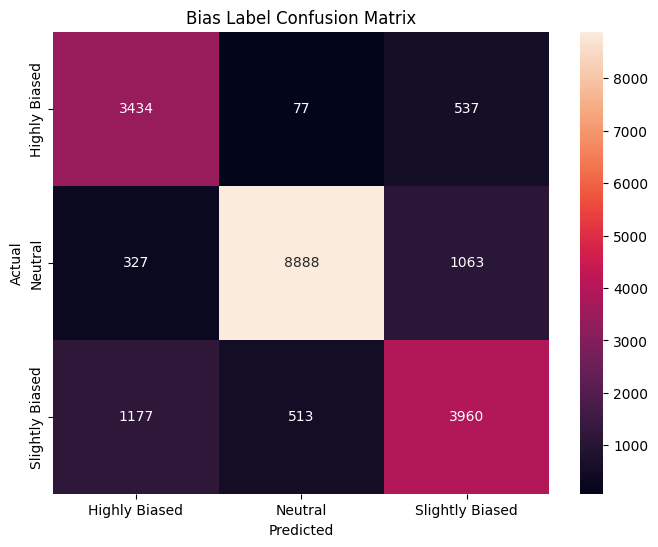

In [34]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_label.classes_, yticklabels=le_label.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Bias Label Confusion Matrix')
plt.show()